In [1]:
from google.colab import files
import pandas as pd

print("Please upload listings.csv(.gz), calendar.csv(.gz), and reviews.csv(.gz)")
uploaded = files.upload()  # Select all 3 files

# Helper function to read CSV (or GZ)
def load_csv(filename):
    if filename.endswith(".gz"):
        return pd.read_csv(filename, compression="gzip", low_memory=False)
    else:
        return pd.read_csv(filename, low_memory=False)

# Initialize empty DataFrames
df_listings, df_calendar, df_reviews = None, None, None

# Read listings
if "listings.csv" in uploaded or "listings.csv.gz" in uploaded:
    fname = "listings.csv.gz" if "listings.csv.gz" in uploaded else "listings.csv"
    df_listings = load_csv(fname)
    print("Listings shape:", df_listings.shape)

# Read calendar
if "calendar.csv" in uploaded or "calendar.csv.gz" in uploaded:
    fname = "calendar.csv.gz" if "calendar.csv.gz" in uploaded else "calendar.csv"
    df_calendar = load_csv(fname)
    print("Calendar shape:", df_calendar.shape)

# Read reviews
if "reviews.csv" in uploaded or "reviews.csv.gz" in uploaded:
    fname = "reviews.csv.gz" if "reviews.csv.gz" in uploaded else "reviews.csv"
    df_reviews = load_csv(fname)
    print("Reviews shape:", df_reviews.shape)


Please upload listings.csv(.gz), calendar.csv(.gz), and reviews.csv(.gz)


Saving calendar.csv.gz to calendar.csv.gz
Saving listings.csv.gz to listings.csv.gz
Saving reviews.csv.gz to reviews.csv.gz
Listings shape: (2762, 79)
Calendar shape: (1008130, 7)
Reviews shape: (75412, 6)


In [2]:
# Step 2: Cleaning

# --- Clean Listings ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Clean Listings ---
if df_listings is not None:
    # Columns to keep
    listings_cols = ["id", "name", "host_id", "neighbourhood_cleansed",
                     "room_type", "price", "minimum_nights", "number_of_reviews",
                     "availability_365"]

    # Add latitude/longitude only if present
    for col in ["latitude", "longitude"]:
        if col in df_listings.columns:
            listings_cols.append(col)

    df_listings = df_listings[listings_cols]

    # Clean price column
    df_listings["price"] = df_listings["price"].astype(str).replace(r'[\$,]', '', regex=True).astype(float)

    print("Cleaned Listings:")
    display(df_listings.head())

# --- Clean Calendar ---
if df_calendar is not None:
    # Clean prices
    for col in ["price", "adjusted_price"]:
        if col in df_calendar.columns:
            df_calendar[col] = pd.to_numeric(
                df_calendar[col].astype(str).replace(r'[\$,]', '', regex=True),
                errors='coerce'
            ).fillna(0)

    # Dates & available column
    if "date" in df_calendar.columns:
        df_calendar["date"] = pd.to_datetime(df_calendar["date"])
    if "available" in df_calendar.columns:
        df_calendar["available"] = df_calendar["available"].map({"t": True, "f": False})

    print("Cleaned Calendar:")
    display(df_calendar.head())

# --- Clean Reviews ---
if df_reviews is not None and "date" in df_reviews.columns:
    df_reviews["date"] = pd.to_datetime(df_reviews["date"])
    print("Cleaned Reviews:")
    display(df_reviews.head())

Cleaned Listings:


,id,name,host_id,neighbourhood_cleansed,room_type,price,minimum_nights,number_of_reviews,availability_365,latitude,longitude
0,42515,Geneva center - Hosting females,185647,Commune de Genève,Private room,89.0,3,81,363,46.20198,6.15672
1,203997,Top location studio 1 block from lake!,1001280,Commune de Genève,Entire home/apt,136.0,5,95,208,46.19964,6.15580
2,276025,Lovely flat by Geneva lake,1442438,Versoix,Entire home/apt,71.0,7,122,309,46.28031,6.16833
3,338682,Top location 1 block from the lake!,1001280,Commune de Genève,Entire home/apt,150.0,6,125,215,46.20708,6.15545
4,399388,Nice modern bedroom with balcony,1994454,Commune de Genève,Private room,55.0,2,59,275,46.18904,6.13908


Cleaned Calendar:


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1650333,2025-06-26,False,0.0,0.0,5,365
1,1650333,2025-06-27,False,0.0,0.0,5,365
2,1650333,2025-06-28,False,0.0,0.0,5,365
3,1650333,2025-06-29,False,0.0,0.0,5,365
4,1650333,2025-06-30,False,0.0,0.0,5,365


Cleaned Reviews:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,42515,563807,2011-09-24,997025,Dounia,"Croix is a wonderful host, very cheerful and w..."
1,42515,1296837,2012-05-17,2348546,D Corinne,This was an ideal place to stay and Croix made...
2,42515,1358497,2012-05-27,2346980,Natalia,I went to Geneva for a one week training and s...
3,42515,2365282,2012-09-21,3503874,Ela,Spent a few days with Croix and she is an abso...
4,42515,3580013,2013-02-19,4185464,Nitin,"Noelle is a fantastic host, she made me feel a..."


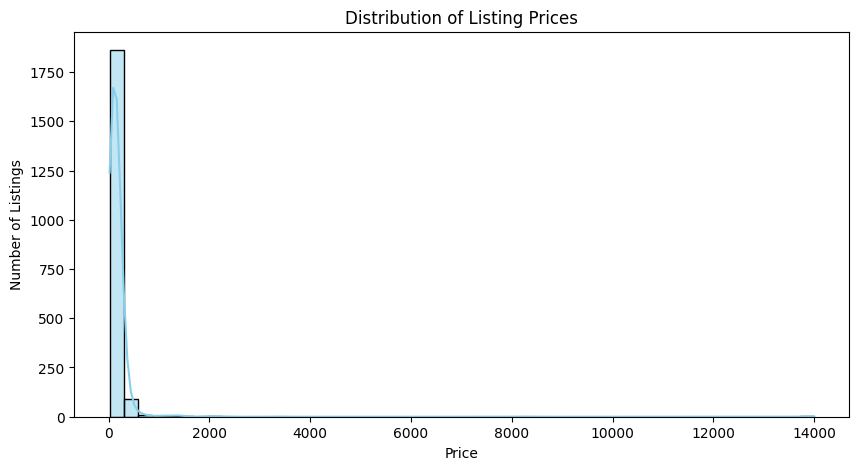

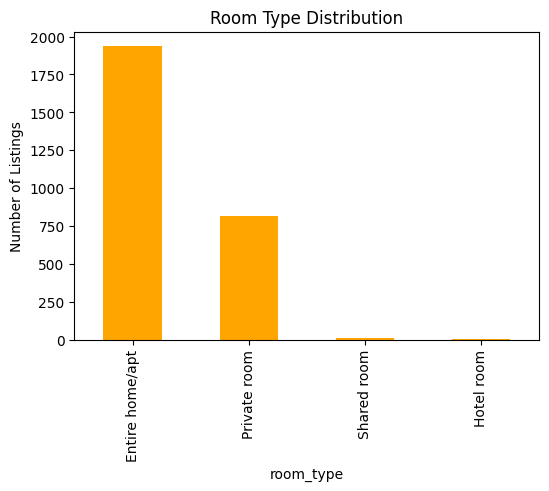

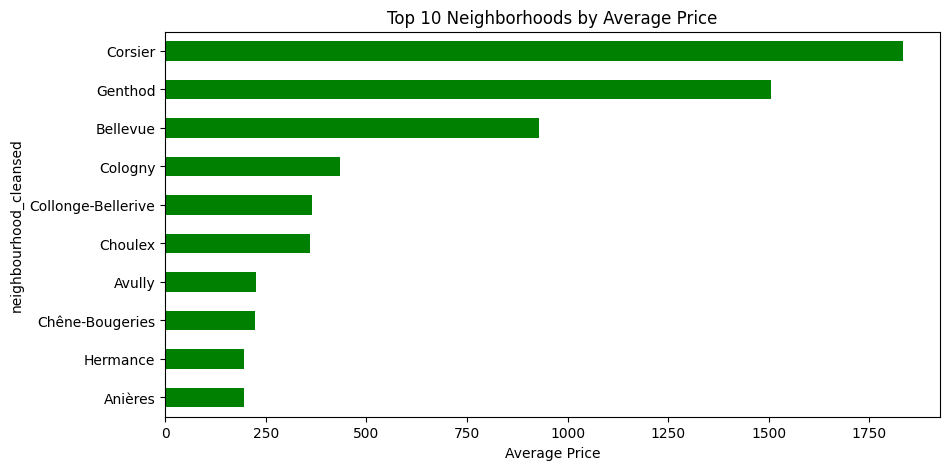

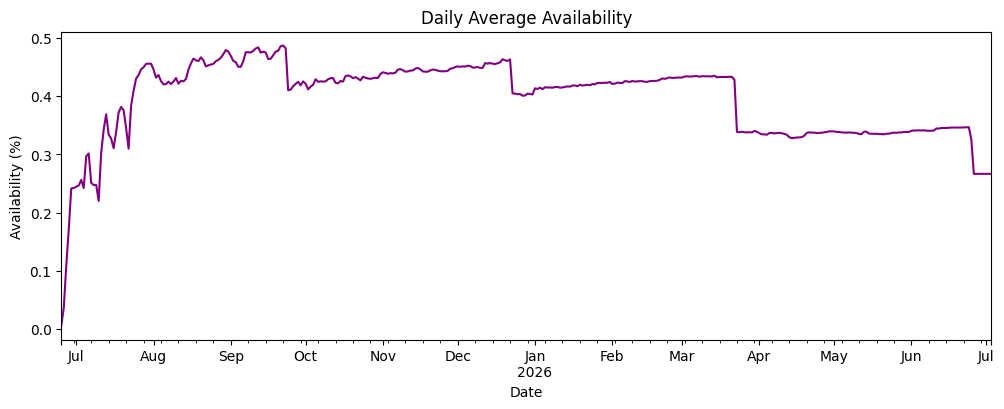

In [3]:
# Step 3: Exploratory Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# --- Price Distribution ---
plt.figure(figsize=(10,5))
sns.histplot(df_listings['price'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Listing Prices")
plt.xlabel("Price")
plt.ylabel("Number of Listings")
plt.show()

# --- Room Type Distribution ---
plt.figure(figsize=(6,4))
df_listings['room_type'].value_counts().plot(kind='bar', color='orange')
plt.title("Room Type Distribution")
plt.ylabel("Number of Listings")
plt.show()

# --- Top 10 Neighborhoods by Average Price ---
top_neighbourhoods = df_listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
top_neighbourhoods.plot(kind='barh', color='green')
plt.title("Top 10 Neighborhoods by Average Price")
plt.xlabel("Average Price")
plt.gca().invert_yaxis()  # highest price on top
plt.show()

# --- Availability Trend Over Time ---
if "date" in df_calendar.columns and "available" in df_calendar.columns:
    availability_trend = df_calendar.groupby('date')['available'].mean()
    plt.figure(figsize=(12,4))
    availability_trend.plot(color='purple')
    plt.title("Daily Average Availability")
    plt.ylabel("Availability (%)")
    plt.xlabel("Date")
    plt.show()

# --- Optional Map of Listings ---
try:
    if "latitude" in df_listings.columns and "longitude" in df_listings.columns:
        import folium
        # Create map centered on mean coordinates
        m = folium.Map(location=[df_listings['latitude'].mean(), df_listings['longitude'].mean()], zoom_start=12)

        # Sample for speed
        for _, row in df_listings.sample(min(500, len(df_listings))).iterrows():
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=2,
                popup=f"${row['price']}" if 'price' in row else "",
                color='blue',
                fill=True
            ).add_to(m)
        m  # show interactive map
    else:
        print("Latitude/Longitude not available — skipping map.")
except KeyError as e:
    print(f"Skipping map due to missing column: {e}")
